# Multiple Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms_multiple import *
from radar_plot import *

In [2]:
df = pd.read_csv('../MFP Regular Sites 2019 - addresses2019 updated.csv')

In [3]:
df.columns

Index(['Site Name', 'Address', 'City', 'State', 'ZIP', 'latitude', 'longitude',
       'Number of Visits in 2019', 'Average Demand per Visit',
       'StDev(Demand per Visit)', 'Unnamed: 10',
       'Demand per Visit == the number of clients serviced on that visit'],
      dtype='object')

In [4]:
locations = df[['latitude', 'longitude']]
data_weights = df['Average Demand per Visit']
data_stdev = df['StDev(Demand per Visit)']

In [5]:
data_stdev

0     46.1
1     57.3
2     45.3
3     28.8
4     53.4
      ... 
65    51.9
66    35.3
67    30.4
68    34.9
69    63.5
Name: StDev(Demand per Visit), Length: 70, dtype: float64

### Simple Test

In [6]:
prob, solver = generate_cvxpy_solve(2, 2)

solver(np.asarray([1., 1.]), np.asarray([[1,1],[1,1]]), np.asarray([1,1]))

(-1.628531753960904e-10,
 array([[0.5, 0.5],
        [0.5, 0.5]]))

In [7]:
prob, solver = generate_cvxpy_solve(5,3)

### Scaling with n

In [8]:
data = []

np.random.seed(5)

# seed 2 - 47 locations

num_types = 3
num_resources = 5
dist_types = np.asarray([.25, .3, 1-.25-.3])
print(dist_types)

weights = np.asarray([[3.9, 3.0, 2.8, 2.7, .1], [3.9, 3.0, .1, 2.7, .1], [3.9, 3.0, 2.8, 2.7, 1.9]])
sum_of_rows = weights.sum(axis=1)
weights = weights / sum_of_rows[:, np.newaxis]

algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full}
             

num_algo = len(algo_list)

num_iterations = 200

# num_iterations = 1

max_n = len(data_stdev)

print(max_n)

[0.25 0.3  0.45]
70


In [ ]:


num_groups = np.arange(5, max_n, 5)

# num_groups = np.arange(5, max_n)
# num_groups = [47]
# num_groups = [10]

for n in tqdm(num_groups):
    print('Num Locations: ' + str(n))

    alloc_diff = np.zeros((len(algo_list), num_iterations, n, num_types, num_resources)) 
    
    for i in range(num_iterations):
        
        index = np.random.choice(max_n, n, replace=False)
        mean_size = np.asarray([dist_types * data_weights[index].to_numpy()[j] for j in range(n)])
        stdev_size = np.asarray([(dist_types**2) * data_stdev[index].to_numpy()[j] for j in range(n)])
             
        budget = np.asarray([np.sum(mean_size)]*num_resources)
        
        size = np.maximum(1, np.random.normal(mean_size, stdev_size))
        
        
        # print('Size: ' + str(size))
        total_num_types = np.sum(size, axis=0)

        
        prob, solver = generate_cvxpy_solve(num_types, num_resources)

        
        opt = offline_opt(budget, size, weights, solver)
        # print('offline opt: ' + str(opt))
        index = 0
        for algo in algo_list:
            
        
            sol, waste = algo_list[algo](budget, size, mean_size, stdev_size, weights, solver)
            # print('budget: ' + str(budget))
            # print('waste: ' + str(waste))
            # print(algo + ' : ' + str(sol))
            if np.around(np.sum(waste), 3) < 0:
                print(f'Error with: {algo} and waste: {waste}')
            envy = 0
            for k in range(num_types):
                for t in range(n):
                    envy = max(envy, np.abs(np.dot(weights[k, :], opt[t, k, :] - sol[t, k, :])))
            alloc_diff[index, i, :, :, :] = opt - sol
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Envy', 'Value': envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'L1', 'Value': np.sum(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Linf', 'Value': np.max(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Waste', 'Value': np.sum(waste)}
            data.append(data_dict)
            index += 1

    index = 0
    for algo in algo_list:
        ex_ante_envy = 0
        for k in range(num_types):
            for t in range(n):
                # print(alloc_diff.shape)
                avg_diff = [np.abs(np.dot(weights[k, :], alloc_diff[index, r, t, k, :])) for r in range(num_iterations)]
                ex_ante_envy = max(ex_ante_envy, np.mean(avg_diff))
        data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Ex-Ante Envy', 'Value': np.max(np.abs(np.mean(alloc_diff[index, :, :], axis=1)))}
        data.append(data_dict)
        index += 1

  0%|          | 0/13 [00:00<?, ?it/s]

Num Locations: 5
Num Locations: 10
Num Locations: 15
Num Locations: 20


In [9]:
# df = pd.DataFrame.from_records(data)
# df.to_csv('./data/multi_fbst.csv', index=False)
df = pd.read_csv('./data/multi_fbst.csv')

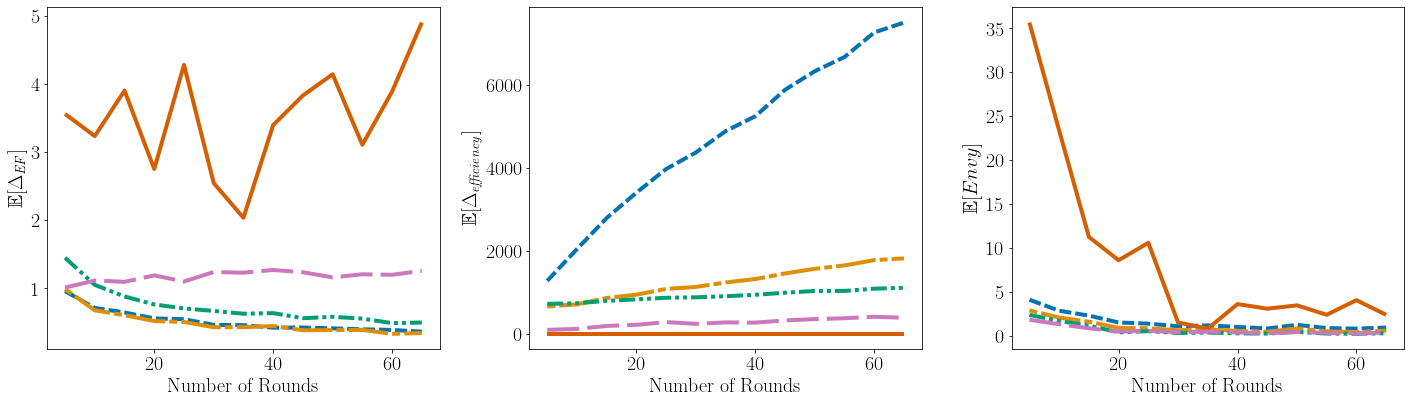

In [10]:

df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Static Allocation', 'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))



plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Linf'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Ex-Ante Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)



axs[0].get_legend().remove()
axs[0].set_ylabel('$\mathbb{E}[\Delta_{\it EF}]$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\mathbb{E}[\Delta_{\it efficiency}]$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$\mathbb{E}[Envy]$')
axs[2].set_xlabel('Number of Rounds')


# axs[2].legend(ncol = 5, loc= 'lower center', bbox_to_anchor=(-1, -.3, 0.5, 0.5))




plt.show()
fg.savefig('./figures/multi_fbst.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)

In [13]:
df.tail

<bound method NDFrame.tail of         NumGroups                   Algorithm          Norm        Value
0               5             Fixed Threshold          Envy     0.616562
1               5             Fixed Threshold            L1    30.451250
2               5             Fixed Threshold          Linf     0.689320
3               5             Fixed Threshold         Waste  1597.752745
4               5  Hope Guardrail $L_T = 1/2$          Envy     0.506514
...           ...                         ...           ...          ...
260320         69             Fixed Threshold  Ex-Ante Envy     0.738640
260321         69  Hope Guardrail $L_T = 1/2$  Ex-Ante Envy     0.384246
260322         69  Hope Guardrail $L_T = 1/3$  Ex-Ante Envy     0.210825
260323         69                 Hope Online  Ex-Ante Envy     1.922327
260324         69                   Hope Full  Ex-Ante Envy     0.210348

[260325 rows x 4 columns]>

### Group by Group Difference

In [60]:
fair_data = []


algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full}             

num_algo = len(algo_list)

num_iterations = 200
n = 10

alloc_diff = np.zeros((len(algo_list), num_iterations, n, num_types, num_resources)) 

for i in tqdm(range(num_iterations)):

    index = np.random.choice(max_n, n, replace=False)
    mean_size = np.asarray([dist_types * data_weights[index].to_numpy()[j] for j in range(n)])
    stdev_size = np.asarray([(dist_types**2) * data_weights[index].to_numpy()[j] for j in range(n)])

    budget = np.asarray([np.sum(mean_size)]*num_resources)

    size = np.maximum(1, np.random.normal(mean_size, stdev_size))


    # print('Size: ' + str(size))
    total_num_types = np.sum(size, axis=0)


    prob, solver = generate_cvxpy_solve(num_types, num_resources)


    # print(num_types, num_resources, budget.shape size.shape, )

    opt = offline_opt(budget, size, weights, solver)

    # print('opt: ' + str(opt))
    index = 0
    
    
    for algo in algo_list:
        # print(algo)
        sol, waste = algo_list[algo](budget, size, mean_size, stdev_size, weights, solver)
        prop_alloc = budget / np.sum(size)   
        
        
        true_envy = 0
        proportional = 0
        nsw = 0
        envy = 0
        
        nsw = np.prod([np.dot(weights[k, :], sol[t, k, :]) ** (size[t,k] / np.sum(size)) for t in range(n) for k in range(num_types)])
        proportional = np.max([max(np.dot(weights[k, :], prop_alloc) - np.matmul(sol[:,k,:], weights[k,:])) for k in range(num_types)])
        true_envy = np.max([max(np.matmul(sol[:,k2,:], weights[k1, :])) - min(np.matmul(sol[:,k1,:], weights[k1,:])) for k1 in range(num_types) for k2 in range(num_types)])
        envy = np.max([np.abs(np.dot(weights[k, :], opt[t, k, :] - sol[t, k, :])) for t in range(n) for k in range(num_types)])
                
        alloc_diff[index, i, :, :, :] = opt - sol
        index += 1
        
        fair_data.append({'Iteration':i, 'Algorithm':algo, 
                          '$\Delta_{\it efficiency}$': np.sum(waste) / n, 
                          '$\Delta_{\it Prop}$': proportional, 
#                           '\textsc{NSW}'.encode('unicode_escape').decode('utf'): nsw,
                         '\textsc{Envy}'.encode('unicode_escape').decode('utf'): true_envy, 
                          '$\Delta_{\it EF}$': envy
                            })
            
# for i in range(n):
#     data.append({'Location': i, 'Algorithm':'Zero', 'Value': 0})
#     ?
    
# index = 0
# for algo in algo_list:
#     ex_ante_envy = np.max([np.mean([np.abs(np.dot(weights[k, :], alloc_diff[index, r, t, k, :])) for r in range(num_iterations)]) for t in range(n) for k in range(num_types)])
#     data_dict = {'Algorithm':algo, 'Iteration': 1, '$\Delta_{\it EF}^+$' : ex_ante_envy}
#     fair_data.append(data_dict)
#     index += 1

  0%|          | 0/200 [00:00<?, ?it/s]

In [64]:
fair_df = pd.DataFrame.from_records(fair_data)
fair_df.to_csv('./data/multi_fbst_fair.csv', index=False)
fair_df = pd.read_csv('./data/multi_fbst_fair.csv')

### Printing Fairness Metrics

In hindsight proportional as the same makes sense, as it will be achieved by people obtaining X_lower, which is the same for all the algorithms (and algorithms ensure they don't run out of budget....)

TODO: Add NSW, EF

In [65]:
fair_df.columns

Index(['Iteration', 'Algorithm', '$\Delta_{\it efficiency}$',
       '$\Delta_{\it Prop}$', '\textsc{Envy}', '$\Delta_{\it EF}$'],
      dtype='object')

In [66]:
# print(fair_df.columns)
# fair_df = fair_df.drop(fair_df.columns[4], axis=1)
fair_df = fair_df.groupby(['Algorithm']).mean()
print(fair_df.drop(['Iteration'], axis=1))

fair_df['$\Delta_{\it efficiency}$'] = (-1)*fair_df['$\Delta_{\it efficiency}$']
fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')] = (-1)*fair_df['\textsc{Envy}'.encode('unicode_escape').decode('utf')]
fair_df['$\Delta_{\it EF}$'] = (-1)* fair_df['$\Delta_{\it EF}$']
fair_df['$\Delta_{\it Prop}$'] = (-1) * fair_df['$\Delta_{\it Prop}$']
# fair_df['$\Delta_{\it EF}^+$'] = (-1)*fair_df['$\Delta_{\it EF}^+$']
print(fair_df)

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                            215.136949             0.313756   
Hope Full                                   17.798132             0.267467   
Hope Guardrail $L_T = 1/2$                  78.473747             0.246616   
Hope Guardrail $L_T = 1/3$                  77.788140             0.249965   
Hope Online                                  0.000044             0.156297   

                            \textsc{Envy}  $\Delta_{\it EF}$  
Algorithm                                                     
Fixed Threshold                  0.000002           0.457828  
Hope Full                        0.568720           0.484522  
Hope Guardrail $L_T = 1/2$       0.517446           0.385973  
Hope Guardrail $L_T = 1/3$       0.972448           0.641961  
Hope Online                      0.705540           0.498078  
            

In [67]:
fair_df = normalize(fair_df).drop(['Iteration'], axis=1)
print(fair_df)

                            $\Delta_{\it efficiency}$  $\Delta_{\it Prop}$  \
Algorithm                                                                    
Fixed Threshold                              0.100000             0.100000   
Hope Full                                    0.925544             0.364579   
Hope Guardrail $L_T = 1/2$                   0.671714             0.483756   
Hope Guardrail $L_T = 1/3$                   0.674583             0.464614   
Hope Online                                  1.000000             1.000000   

                            \textsc{Envy}  $\Delta_{\it EF}$  
Algorithm                                                     
Fixed Threshold                  1.000000           0.747375  
Hope Full                        0.473650           0.653523  
Hope Guardrail $L_T = 1/2$       0.521104           1.000000  
Hope Guardrail $L_T = 1/3$       0.100000           0.100000  
Hope Online                      0.347024           0.605863  


4
{'Fixed Threshold': <function fixed_threshold at 0x7fdef6803b70>, 'Hope Guardrail $L_T = 1/2$': <function <lambda> at 0x7fdf5026e048>, 'Hope Guardrail $L_T = 1/3$': <function <lambda> at 0x7fdef56c7e18>}
{'Hope Guardrail $L_T = 1/2$': <function <lambda> at 0x7fdf5026e048>, 'Hope Online': <function hope_online at 0x7fdef6803a60>, 'Hope Full': <function hope_full at 0x7fdef6803ae8>}


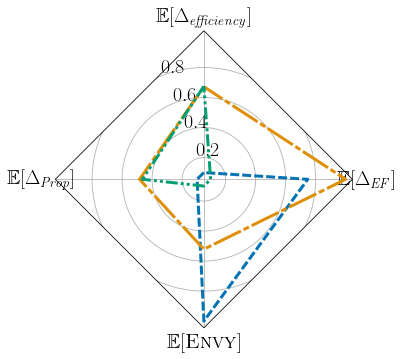

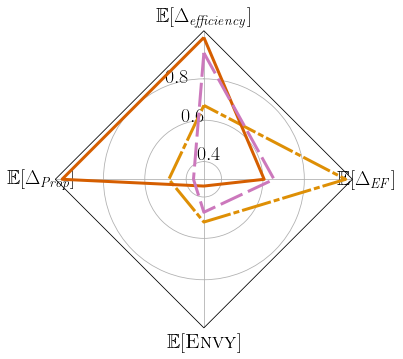

In [68]:
# number of variable


from math import pi
plt.style.use('PaperDoubleFig.mplstyle.txt')

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')




N = len(list(fair_df))
print(N)
theta = radar_factory(N, frame='polygon')

spoke_labels = ['$\\mathbb{E}[\\Delta_{\\it efficiency}]$', '$\\mathbb{E}[\\Delta_{\\it Prop}]$', '$\\mathbb{E}[\\textsc{Envy}]$', '$\\mathbb{E}[\\Delta_{\\it EF}]$']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title('Comparison of Fairness Metrics',  position=(0.5, 1.1), ha='center')
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]

first_plot = { algo : algo_list[algo] for algo in ['Fixed Threshold', 'Hope Guardrail $L_T = 1/2$', 'Hope Guardrail $L_T = 1/3$']}
second_plot = { algo : algo_list[algo] for algo in ['Hope Guardrail $L_T = 1/2$', 'Hope Online', 'Hope Full']}
print(first_plot)
print(second_plot)

index = 0
for algo in first_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = sns.color_palette('colorblind', len(algo_list))[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

# plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/multi_fbst_leontief_guardrail_radar.pdf')
plt.show()





fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])


dashesStyles = [
            [2,1,10,1],
            [1000,1],[8,2]]

color_list = [sns.color_palette("colorblind", len(algo_list))[1], sns.color_palette("colorblind", len(algo_list))[3], sns.color_palette("colorblind", len(algo_list))[4]]

index = 0
for algo in second_plot:
    values = fair_df.loc[algo].to_numpy()
    ax.plot(theta, values, linewidth=3, dashes=dashesStyles[index], label=algo, color = color_list[index])
    ax.fill(theta, values, color = sns.color_palette('colorblind', len(algo_list))[index],  alpha=0)
    index += 1
ax.set_varlabels(spoke_labels)

# plt.legend(loc='right', bbox_to_anchor=(2.15, .5))

plt.savefig('./figures/multi_fbst_leontief_heuristic_radar.pdf')
plt.show()


